## Margin Recommender by Clustering

In this notebook we will try to predict recommended margin range for when a customer wants to by a new product by using unsupervised learning. 
More specifically we will first cluster products and then customers. After the clustering is performed we can calcuate the upper and lower bound for recommended margin with the following formula: 



We start off by importing the necessary libraries, and reading in the data.

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

filepath = '/Users/hermansamuelsen/Desktop/Infor-Cogito/CogitoXInfor-h24/ECOMMRecords2020.csv'
data = pd.read_csv(filepath)
data_original = data.copy()


### Helper Functions
This section contains a variety of important functions used throughout the project. 

In [49]:
def get_coefficient_variation(data, feature): 
    '''
    The function calculates the coefficient of variation (CV) of the "Margin" for each category in the specified feature.

    Returns a sorted DataFrame with the mean, standard deviation, and CV for each category.
    '''

    grouped_data = data.groupby(feature)
    mean, std = grouped_data["Margin"].mean(), grouped_data["Margin"].std()
    df = pd.concat([mean, std], axis = 1).reset_index()
    df.columns = [feature, "Mean", "Std"]
    df["CoefficientOfVariation"] = (df["Std"]/df["Mean"])**2

    return df.sort_values(by = "CoefficientOfVariation")


In [50]:


def split_data(feature, data):
    '''
    Splits a DataFrame into multiple DataFrames based on the unique values of a specified categorical feature.

    Parameters:
    - feature: The column name to split the DataFrame by.
    - data: The DataFrame to split.

    Returns:
    - A dictionary where keys are unique feature values and values are the corresponding DataFrames.
    '''

    categories = list(data[feature].unique())
    dataframes = {}

    for c in categories: 
        df = data[data[feature] == c]
        dataframes[c] = df
        
    return dataframes


In [51]:
from datetime import datetime

'''
This cell contains all functions that are used to create new features used by the KMeans
algorithms to group products in clusters. 
More functions are needed to create more features to achieve better clustering results. 
'''

def add_average_margin_feature(dataframe):
    means = dataframe.groupby("ProductName")["Margin"].mean().reset_index()
    means.columns = ["ProductName", "MeanMargin"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 
    

def add_average_cost_per_unit_feature(dataframe):
    dataframe.loc[:, "CostPerUnit"] = dataframe["Cost"]/dataframe["Quantity"]
    means = dataframe.groupby("ProductName")["CostPerUnit"].mean().reset_index()
    means.columns = ["ProductName", "MeanCostPerUnit"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 

def add_average_sales_in_past_per_product(n_months, dataframe):
    dataframe["OrderDate"] = pd.to_datetime(dataframe["OrderDate"])
    last_date = dataframe["OrderDate"].max()
    n_months_ago = last_date - pd.DateOffset(months = n_months)
    filtered_data = dataframe[dataframe["OrderDate"] >= n_months_ago]
    meanSales = filtered_data.groupby("ProductName")["Sales"].mean().reset_index()
    meanSales.columns = ["ProductName", "AverageSalesPastMonths"]
    new_df = pd.merge(meanSales, dataframe, on = "ProductName")
    return new_df

def number_of_orders_per_product(dataframe): 
    product_order_counts = dataframe.groupby("ProductID")["OrderID"].count().reset_index()
    product_order_counts = product_order_counts.rename(columns = {"OrderID" : "NumberOfOrders"})
    dataframe = dataframe.merge(product_order_counts, on = "ProductID", how = "left")
    return dataframe
    
def add_total_sales_for_product(dataframe): 
    product_sales = data.groupby("ProductID")["Sales"].sum().reset_index()
    product_sales.columns = ["ProductID", "TotalSales"]
    new_df = pd.merge(dataframe, product_sales, on = "ProductID", how = "left")
    return new_df

# We can do for multiple past months instead of total. Implement this. 

In [52]:
def feature_engineering(dataframes : dict): 
    '''
    The function applies multiple feature engineerings steps to each dataframe in the input dictionary. 

    It then returns a dictionary with the engineered dataframes. 
    '''

    engineered_data = {}

    for category in dataframes.keys(): 
        df = dataframes[category].copy()
        df = add_average_margin_feature(df)
        df = add_average_cost_per_unit_feature(df)
        df = add_average_sales_in_past_per_product(12, df)
        df = number_of_orders_per_product(df)
        df = add_total_sales_for_product(df)
        engineered_data[category] = df
    
    return engineered_data


In [53]:


def standardize_features(dataframes : dict, features : list): 
    '''
    The functions standardizes specified features in each dataframe. 

    Returns a new dictionary containing the dataframes containing the scaled specified features.
    '''
    dataframes_scaled = {}

    for category in dataframes.keys():

        data = dataframes[category][features]
        ss = StandardScaler()
        data_scaled = ss.fit_transform(data)
        data_scaled = pd.DataFrame(data_scaled, columns = ss.get_feature_names_out())
        dataframes_scaled[category] = data_scaled
    
    return dataframes_scaled



In [54]:
def find_optimal_k(dataframes : dict): 
    '''
    Identifies the optimal number of clusters for KMeans using the elbow method and plotting the silhouette score. 

    Returns a plot of the interia score and silhouette score versus number of clusters for each of the dataframes 
    in the input dictionary. 
    '''
    ks = [x for x in range(2, 11)]
    inertia_scores = []
    silhouette_scores = []
    
    for category in dataframes.keys(): 
        data = dataframes[category]
        inertia = []
        silhouette = []
        for k in ks: 
            model = KMeans(n_clusters = k, random_state = 42, init = 'k-means++')
            predicted = model.fit_predict(data)
            inertia.append(model.inertia_)
            silhouette.append(silhouette_score(data, predicted))

        inertia_scores.append(inertia)
        silhouette_scores.append(silhouette)
    
    fig, ax = plt.subplots(nrows = len(dataframes.keys()), ncols = 2, figsize = (15, 14), squeeze=False)
    for i in range(len(dataframes.keys())): 
        ax[i, 0].plot(ks, inertia_scores[i])
        ax[i, 1].plot(ks, silhouette_scores[i])
        ax[i, 0].set_xlabel("Number of Clusters")
        ax[i, 0].set_ylabel("Inertia")
        ax[i, 1].set_xlabel("Number of Clusters")
        ax[i, 1].set_ylabel("Silhouette Score")
        fig.text(0.5, 0.95 - (i*0.3), f"{list(dataframes.keys())[i]}", ha = 'center', fontsize = 14, weight = "bold")

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [55]:
def visualize_clusters(model, data):
    '''
    The function visualizes clusters produced by a clustering model in 2D space, by 
    using t-SNE for dimensionality reduction. 

    Returns a 2D scatter plot of the data points colored by their predicted cluster labels. 
    '''
    embedding = TSNE(n_components=2,
        init="pca",
        max_iter=500,
        n_iter_without_progress=150,
        perplexity=10,
        random_state=0)

    data_2D = embedding.fit_transform(data)
    
    labels = model.predict(data)
    cmap = plt.get_cmap('brg', model.n_clusters)

    unique_labels = set(labels)
    fig, ax = plt.subplots(figsize = (15, 10))

    for l in unique_labels: 
        cluster = data_2D[labels == l]
        ax.scatter(cluster[:, 0], cluster[:, 1], c = cmap(l), label = f"Cluster {l}")

    ax.legend()
    plt.show()



### Product Clustering

First, we create two essential features for the project. One of these will be used later for feature engineering, while the other—margin—is the target feature that we aim to predict.

In [56]:
data["Cost"] = (data["Sales"] - data["Profit"])/data["Quantity"]
data["Margin"] = data["Profit"]/data["Sales"]

In [57]:

category = get_coefficient_variation(data, "Category")
sub_category = get_coefficient_variation(data, "SubCategory")

In [58]:
category
# CoefficientOfVariation is here low enough to only use categories for groupings. This gives more data point to fit 
# the clustering models within each group. We therefore dont need to group using the SubCategory. 

,Category,Mean,Std,CoefficientOfVariation
2,Technology,0.162107,0.221497,1.866943
1,Office Supplies,0.128125,0.567459,19.615620
0,Furniture,0.038584,0.354826,84.568818


In [59]:
sub_category

,SubCategory,Mean,Std,CoefficientOfVariation
10,Labels,0.435285,0.064162,0.021728
12,Paper,0.422968,0.066004,0.024352
7,Envelopes,0.422465,0.065931,0.024355
6,Copiers,0.319432,0.124438,0.151757
2,Art,0.251755,0.108777,0.186689
8,Fasteners,0.327422,0.175865,0.288497
0,Accessories,0.227836,0.156166,0.469816
15,Supplies,0.119110,0.175106,2.161255
13,Phones,0.113920,0.182104,2.555285
16,Tables,-0.158389,0.271052,2.928571


In [60]:
grouped_dataframes = split_data("Category", data)
grouped_dataframes.keys()

dict_keys(['Furniture', 'Office Supplies', 'Technology'])

In [61]:
data = feature_engineering(grouped_dataframes)


In [62]:
features = ["AverageSalesPastMonths", "MeanCostPerUnit", "MeanMargin", "NumberOfOrders", "TotalSales"]
#features = ["AverageSalesPastMonths", "MeanCostPerUnit", "MeanMargin", "TotalSales"]
dataframes_scaled = standardize_features(data, features)

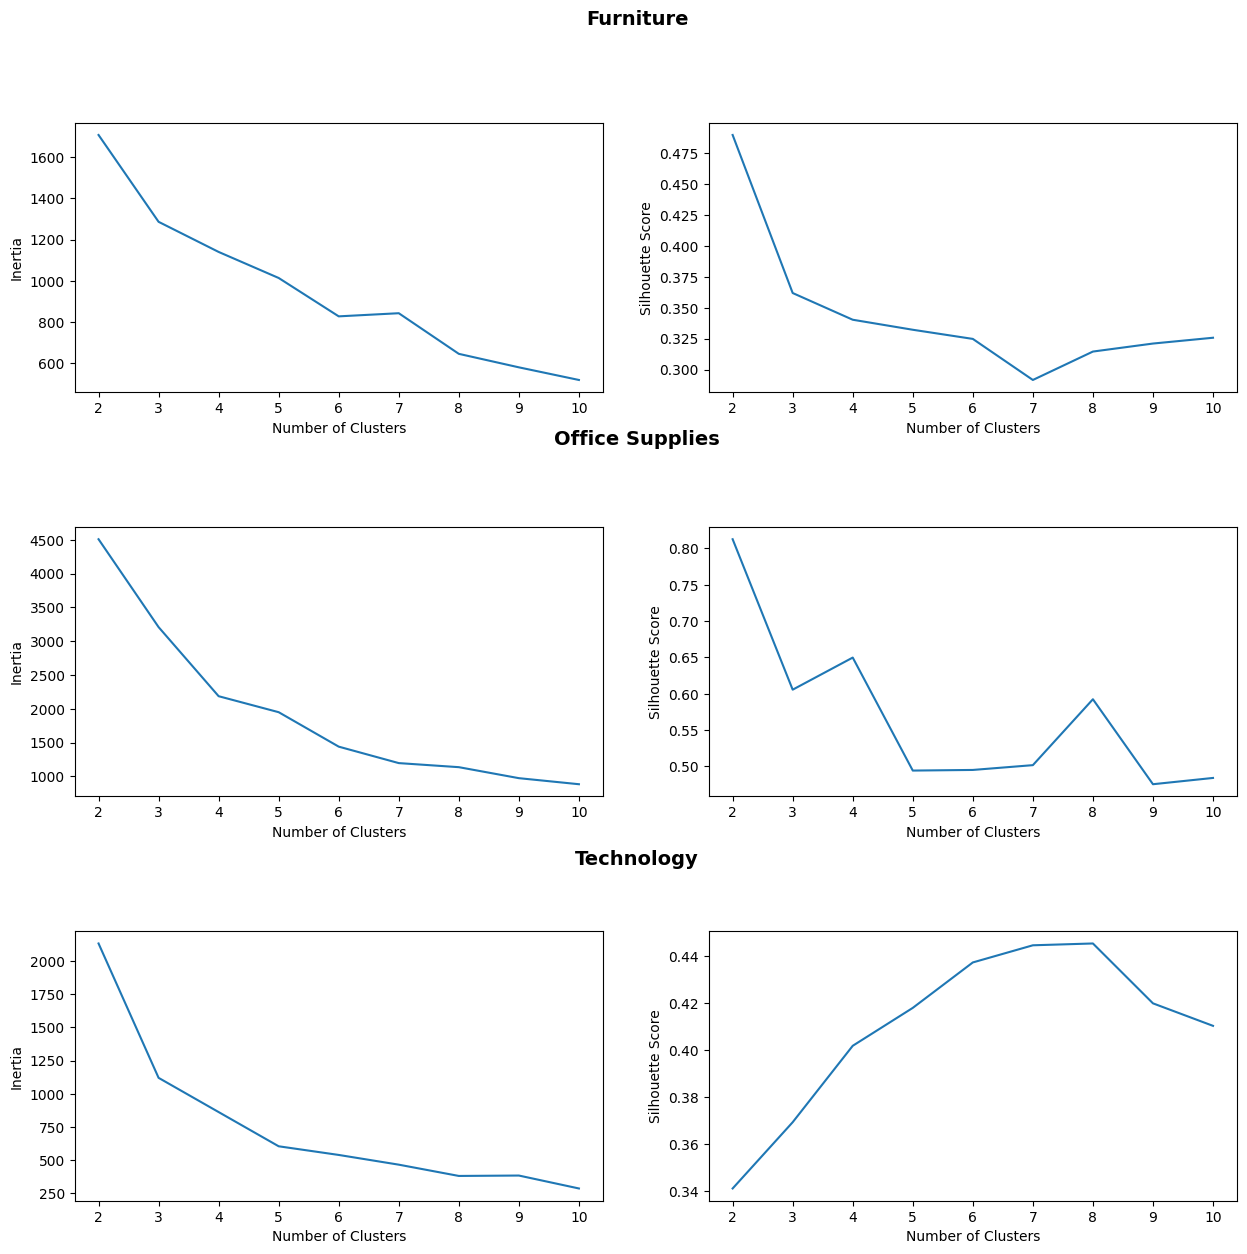

In [63]:
find_optimal_k(dataframes_scaled)

In [64]:
dataframes_scaled.keys()

dict_keys(['Furniture', 'Office Supplies', 'Technology'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


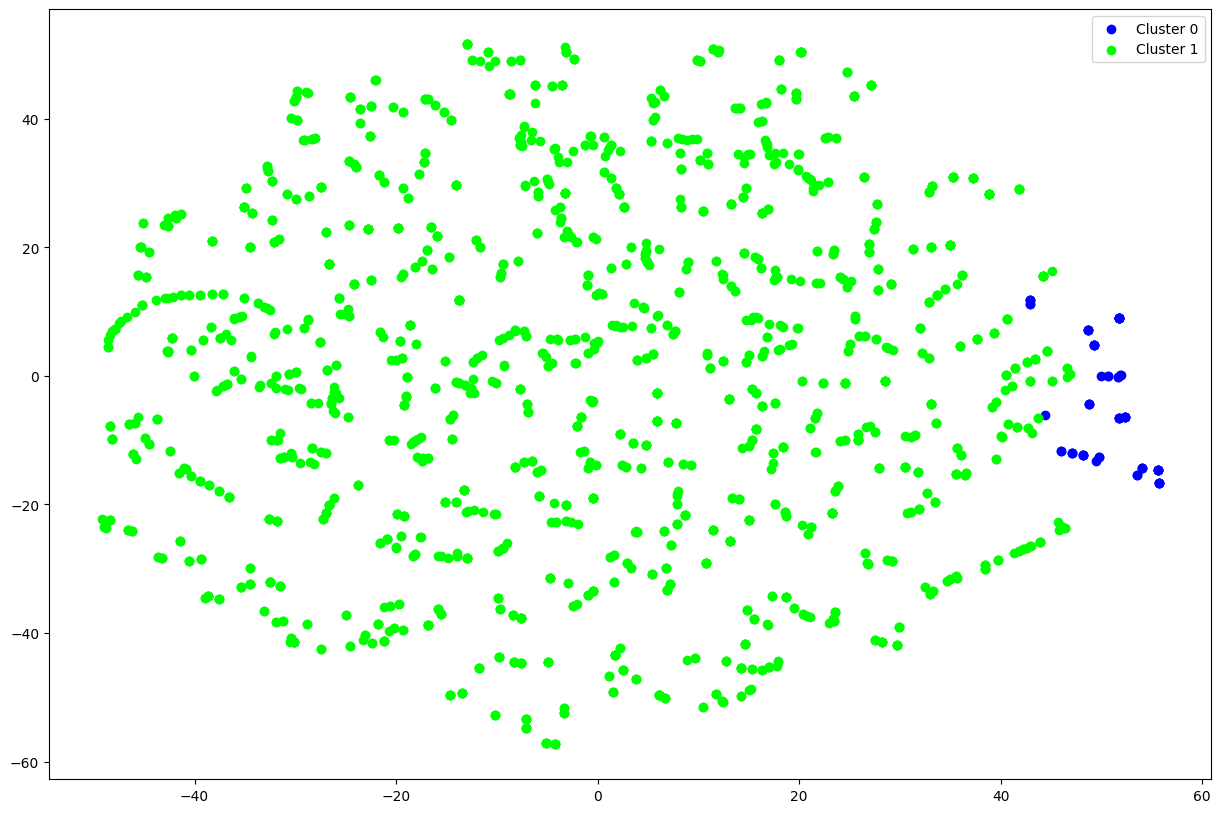

In [65]:
model = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
model.fit(dataframes_scaled["Office Supplies"])

visualize_clusters(model, dataframes_scaled["Office Supplies"])

In [66]:
data = grouped_dataframes["Technology"].copy()
data["Clusters"] = labels
get_coefficient_variation(data, "Clusters")

NameError: name 'labels' is not defined

In [ ]:
data[labels == 1]["SubCategory"].value_counts()

NameError: name 'labels' is not defined

### Customer Clustering